# ⚡ Data Generator - Pipeline de Données Optimisé

## 🎯 Objectifs

**Mission** : Créer un générateur de données haute performance pour l'entraînement

**Défis techniques** :
- **Volume** : 5000 images Cityscapes (train + val)
- **Taille** : Images 2048x1024 → Redimensionnement 512x1024
- **Conversion** : Mapping 34 classes → 8 catégories en temps réel
- **Performance** : Chargement optimisé, gestion mémoire intelligente

**Architecture tf.keras.utils.Sequence** :
- Chargement lazy et parallélisé
- Conversion de labels automatique
- Redimensionnement adaptatif
- Cache LRU pour optimisation
- Gestion mémoire robuste

---

## 📚 Imports et Configuration

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path
import json
import time
from functools import lru_cache
import gc

# Image processing
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Deep Learning
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Utilities
from tqdm.auto import tqdm
import psutil

# Configuration
plt.style.use('seaborn-v0_8')

# Chemins du projet
PROJECT_ROOT = Path("C:/Tonton/OpenClassrooms/Projet_7_traiter_images_systeme_embarque_voiture_autonome")
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"
OUTPUTS_DIR = NOTEBOOKS_DIR / "outputs"
FIGURES_DIR = NOTEBOOKS_DIR / "figures"

# Chemins des données
DATA_ROOT = PROJECT_ROOT / "data"
GTFINE_ROOT = DATA_ROOT / "gtFine"
LEFTIMG_ROOT = DATA_ROOT / "leftImg8bit"

print("✅ Configuration chargée")
print(f"🔗 TensorFlow: {tf.__version__}")
print(f"📁 Données: {DATA_ROOT}")


✅ Configuration chargée
🔗 TensorFlow: 2.15.1
📁 Données: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\data


## 🔧 Configuration du Générateur

In [2]:
# Configuration globale
GENERATOR_CONFIG = {
    'input_shape': (512, 1024, 3),
    'num_classes': 8,
    'batch_size': 16,
    'shuffle': True,
    'preprocessing': {
        'normalization': 'imagenet',  # 'imagenet', 'zero_one', 'custom'
        'interpolation': cv2.INTER_LINEAR,
        'dtype': np.float32
    },
    'performance': {
        'use_cache': True,
        'cache_size': 128,  # Nombre d'images en cache
        'num_workers': 4,
        'prefetch_factor': 2
    }
}

# Charger le mapping des classes
try:
    with open(OUTPUTS_DIR / "class_mapping.json", 'r') as f:
        class_mapping = json.load(f)
    
    # Conversion vers numpy array pour performance
    ID_TO_8_CATEGORIES = np.array([class_mapping['id_to_8_categories'].get(str(i), 7) 
                                   for i in range(256)], dtype=np.uint8)
    
    print("✅ Mapping des classes chargé")
    print(f"📊 Mapping: 34 classes Cityscapes → {GENERATOR_CONFIG['num_classes']} catégories")
    
except FileNotFoundError:
    print("⚠️ Fichier de mapping non trouvé, utilisation mapping par défaut")
    ID_TO_8_CATEGORIES = np.arange(256) % 8

✅ Mapping des classes chargé
📊 Mapping: 34 classes Cityscapes → 8 catégories


## 📂 Collecte et Indexation des Données

In [3]:
class DatasetIndexer:
    """
    Indexe et organise les fichiers du dataset Cityscapes
    """
    
    def __init__(self, gtfine_root, leftimg_root=None):
        self.gtfine_root = Path(gtfine_root)
        self.leftimg_root = Path(leftimg_root) if leftimg_root else None
        self.dataset_index = {}
        
    def scan_dataset(self):
        """
        Scanne le dataset et crée un index complet
        """
        print("🔍 Indexation du dataset...")
        
        for split in ['train', 'val']:
            split_path = self.gtfine_root / split
            if not split_path.exists():
                continue
                
            self.dataset_index[split] = []
            
            for city_dir in tqdm(split_path.iterdir(), desc=f"Scan {split}"):
                if not city_dir.is_dir():
                    continue
                    
                # Fichiers d'annotations
                label_files = list(city_dir.glob("*_gtFine_labelIds.png"))
                
                for label_file in label_files:
                    # Construire le chemin de l'image correspondante
                    base_name = label_file.stem.replace('_gtFine_labelIds', '')
                    
                    # Image originale (si disponible)
                    if self.leftimg_root:
                        img_path = self.leftimg_root / split / city_dir.name / f"{base_name}_leftImg8bit.png"
                        if not img_path.exists():
                            # Essayer .jpg
                            img_path = self.leftimg_root / split / city_dir.name / f"{base_name}_leftImg8bit.jpg"
                    else:
                        img_path = None
                    
                    # Fichiers auxiliaires
                    color_file = label_file.parent / f"{base_name}_gtFine_color.png"
                    instance_file = label_file.parent / f"{base_name}_gtFine_instanceIds.png"
                    
                    self.dataset_index[split].append({
                        'image_path': str(img_path) if img_path and img_path.exists() else None,
                        'label_path': str(label_file),
                        'color_path': str(color_file) if color_file.exists() else None,
                        'instance_path': str(instance_file) if instance_file.exists() else None,
                        'city': city_dir.name,
                        'base_name': base_name,
                        'split': split
                    })
        
        # Statistiques
        total_samples = sum(len(samples) for samples in self.dataset_index.values())
        
        print(f"✅ Indexation terminée:")
        for split, samples in self.dataset_index.items():
            available_images = sum(1 for s in samples if s['image_path'] is not None)
            print(f"   • {split}: {len(samples)} annotations, {available_images} images")
        print(f"   • Total: {total_samples} échantillons")
        
        return self.dataset_index
    
    def get_split_data(self, split, has_images_only=False):
        """
        Retourne les données pour un split spécifique
        """
        if split not in self.dataset_index:
            return []
            
        data = self.dataset_index[split]
        
        if has_images_only:
            data = [item for item in data if item['image_path'] is not None]
            
        return data
    
    def save_index(self, output_path):
        """
        Sauvegarde l'index pour réutilisation
        """
        with open(output_path, 'w') as f:
            json.dump(self.dataset_index, f, indent=2)
        print(f"💾 Index sauvegardé: {output_path}")

# Création de l'index
print("\n📂 INDEXATION DU DATASET")
print("=" * 40)

indexer = DatasetIndexer(GTFINE_ROOT, LEFTIMG_ROOT)
dataset_index = indexer.scan_dataset()

# Sauvegarde de l'index
indexer.save_index(OUTPUTS_DIR / "dataset_index.json")


📂 INDEXATION DU DATASET
🔍 Indexation du dataset...


Scan train: 0it [00:00, ?it/s]

Scan val: 0it [00:00, ?it/s]

✅ Indexation terminée:
   • train: 2975 annotations, 2975 images
   • val: 500 annotations, 500 images
   • Total: 3475 échantillons
💾 Index sauvegardé: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\dataset_index.json


## ⚡ Classe Sequence Optimisée

In [4]:
class CityscapesSequence(Sequence):
    """
    Générateur de données optimisé pour Cityscapes avec tf.keras.utils.Sequence
    
    Features:
    - Chargement lazy et mise en cache intelligente
    - Conversion automatique des labels 34→8 classes
    - Redimensionnement adaptatif
    - Normalisation configurable
    - Gestion mémoire robuste
    """
    
    def __init__(self, data_list, batch_size=16, input_shape=(512, 1024, 3), 
                 num_classes=8, shuffle=True, augmentations=None, use_cache=True):
        
        self.data_list = data_list
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.augmentations = augmentations
        self.use_cache = use_cache
        
        # Cache LRU pour optimisation
        if use_cache:
            self._load_image_cached = lru_cache(maxsize=GENERATOR_CONFIG['performance']['cache_size'])(
                self._load_image_uncached
            )
            self._load_label_cached = lru_cache(maxsize=GENERATOR_CONFIG['performance']['cache_size'])(
                self._load_label_uncached
            )
        else:
            self._load_image_cached = self._load_image_uncached
            self._load_label_cached = self._load_label_uncached
        
        # Indices pour shuffle
        self.indices = np.arange(len(self.data_list))
        if self.shuffle:
            np.random.shuffle(self.indices)
            
        print(f"✅ CityscapesSequence initialisé:")
        print(f"   • Échantillons: {len(self.data_list)}")
        print(f"   • Batch size: {self.batch_size}")
        print(f"   • Batches par époque: {len(self)}")
        print(f"   • Cache activé: {self.use_cache}")
    
    def __len__(self):
        """Nombre de batches par époque"""
        return int(np.ceil(len(self.data_list) / self.batch_size))
    
    def __getitem__(self, idx):
        """
        Génère un batch de données
        """
        # Indices pour ce batch
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Pré-allocation des arrays
        batch_images = np.zeros((len(batch_indices),) + self.input_shape, dtype=np.float32)
        batch_labels = np.zeros((len(batch_indices), self.input_shape[0], self.input_shape[1]), dtype=np.uint8)
        
        # Chargement du batch
        for i, data_idx in enumerate(batch_indices):
            try:
                data_item = self.data_list[data_idx]
                
                # Chargement image et label
                image = self._load_image_cached(data_item['image_path'], data_item['color_path'])
                label = self._load_label_cached(data_item['label_path'])
                
                if image is not None and label is not None:
                    batch_images[i] = image
                    batch_labels[i] = label
                    
            except Exception as e:
                print(f"⚠️ Erreur chargement batch {idx}, item {i}: {e}")
                # Garder les zeros pré-alloués en cas d'erreur
                continue
        
        return batch_images, batch_labels
    
    def _load_image_uncached(self, image_path, color_path_fallback):
        """
        Charge et préprocesse une image (version non cachée)
        """
        # Priorité à l'image originale, fallback sur image colorée
        path_to_use = image_path if image_path else color_path_fallback
        
        if not path_to_use or not Path(path_to_use).exists():
            return None
            
        try:
            # Chargement avec OpenCV (plus rapide que PIL)
            image = cv2.imread(path_to_use)
            if image is None:
                return None
                
            # Conversion BGR → RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Redimensionnement
            if image.shape[:2] != self.input_shape[:2]:
                image = cv2.resize(image, (self.input_shape[1], self.input_shape[0]), 
                                 interpolation=GENERATOR_CONFIG['preprocessing']['interpolation'])
            
            # Normalisation
            image = self._normalize_image(image)
            
            return image.astype(np.float32)
            
        except Exception as e:
            print(f"⚠️ Erreur chargement image {path_to_use}: {e}")
            return None
    
    def _load_label_uncached(self, label_path):
        """
        Charge et convertit un mask de labels (version non cachée)
        """
        if not Path(label_path).exists():
            return None
            
        try:
            # Chargement en mode L (luminance) obligatoire pour labelIds
            label = np.array(Image.open(label_path).convert('L'))
            
            # Redimensionnement si nécessaire
            if label.shape != self.input_shape[:2]:
                label = cv2.resize(label, (self.input_shape[1], self.input_shape[0]), 
                                 interpolation=cv2.INTER_NEAREST)  # NEAREST pour labels
            
            # Conversion 34 classes → 8 catégories
            converted_label = ID_TO_8_CATEGORIES[label]
            
            return converted_label.astype(np.uint8)
            
        except Exception as e:
            print(f"⚠️ Erreur chargement label {label_path}: {e}")
            return None
    
    def _normalize_image(self, image):
        """
        Normalise l'image selon la configuration
        """
        normalization = GENERATOR_CONFIG['preprocessing']['normalization']
        
        if normalization == 'imagenet':
            # Normalisation ImageNet
            mean = np.array([123.675, 116.28, 103.53])
            std = np.array([58.395, 57.12, 57.375])
            image = (image - mean) / std
            
        elif normalization == 'zero_one':
            # Normalisation [0, 1]
            image = image / 255.0
            
        elif normalization == 'custom':
            # Normalisation custom [-1, 1]
            image = (image / 127.5) - 1.0
            
        return image
    
    def on_epoch_end(self):
        """
        Appelé à la fin de chaque époque
        """
        if self.shuffle:
            np.random.shuffle(self.indices)
            
        # Nettoyage cache si nécessaire
        if self.use_cache and hasattr(self, '_load_image_cached'):
            cache_info = self._load_image_cached.cache_info()
            if cache_info.currsize > GENERATOR_CONFIG['performance']['cache_size'] * 0.9:
                self._load_image_cached.cache_clear()
                self._load_label_cached.cache_clear()
                gc.collect()
    
    def get_cache_info(self):
        """
        Retourne les informations de cache
        """
        if self.use_cache and hasattr(self, '_load_image_cached'):
            return {
                'image_cache': self._load_image_cached.cache_info(),
                'label_cache': self._load_label_cached.cache_info()
            }
        return None
    
    def get_sample(self, idx):
        """
        Retourne un échantillon spécifique (utile pour debug)
        """
        data_item = self.data_list[idx]
        image = self._load_image_cached(data_item['image_path'], data_item['color_path'])
        label = self._load_label_cached(data_item['label_path'])
        return image, label, data_item

print("\n⚡ CLASSE CITYSCAPES SEQUENCE DÉFINIE")
print("=" * 40)


⚡ CLASSE CITYSCAPES SEQUENCE DÉFINIE


## 🧪 Test et Benchmarking du Générateur

In [5]:
def benchmark_generator():
    """
    Benchmark les performances du générateur
    """
    print("🧪 BENCHMARK DU GÉNÉRATEUR")
    print("=" * 40)
    
    # Données de test (train split)
    train_data = indexer.get_split_data('train', has_images_only=False)  # Test avec color fallback
    
    if len(train_data) == 0:
        print("❌ Aucune donnée d'entraînement trouvée")
        return None
    
    print(f"📊 Test avec {len(train_data)} échantillons")
    
    # Test avec différentes configurations
    configs_to_test = [
        {'batch_size': 8, 'use_cache': False, 'name': 'Baseline (no cache)'},
        {'batch_size': 8, 'use_cache': True, 'name': 'Optimisé (avec cache)'},
        {'batch_size': 16, 'use_cache': True, 'name': 'Batch 16 (avec cache)'},
    ]
    
    results = []
    
    for config in configs_to_test:
        print(f"\n⏱️ Test: {config['name']}")
        
        # Limitation pour benchmark (premiers 100 échantillons)
        test_data = train_data[:100]
        
        # Création du générateur
        generator = CityscapesSequence(
            test_data, 
            batch_size=config['batch_size'],
            input_shape=GENERATOR_CONFIG['input_shape'],
            use_cache=config['use_cache']
        )
        
        # Benchmark
        start_time = time.time()
        successful_batches = 0
        total_samples = 0
        
        try:
            for i in range(min(30, len(generator))):  # Test 5 batches max
                batch_x, batch_y = generator[i]
                successful_batches += 1
                total_samples += batch_x.shape[0]
                
                # Vérifications
                assert batch_x.shape[1:] == GENERATOR_CONFIG['input_shape']
                assert batch_y.shape[1:] == GENERATOR_CONFIG['input_shape'][:2]
                assert batch_y.max() < GENERATOR_CONFIG['num_classes']
                
        except Exception as e:
            print(f"❌ Erreur durant le test: {e}")
            continue
        
        end_time = time.time()
        duration = end_time - start_time
        
        # Métriques
        samples_per_second = total_samples / duration if duration > 0 else 0
        
        result = {
            'config': config['name'],
            'batch_size': config['batch_size'],
            'use_cache': config['use_cache'],
            'duration': duration,
            'successful_batches': successful_batches,
            'total_samples': total_samples,
            'samples_per_second': samples_per_second
        }
        
        results.append(result)
        
        print(f"   ✅ {successful_batches} batches, {total_samples} échantillons")
        print(f"   ⚡ {samples_per_second:.1f} échantillons/seconde")
        
        # Info cache
        if config['use_cache']:
            cache_info = generator.get_cache_info()
            if cache_info:
                print(f"   💾 Cache hits: {cache_info['image_cache'].hits}/{cache_info['image_cache'].hits + cache_info['image_cache'].misses}")
    
    return results

# Benchmark des performances
benchmark_results = benchmark_generator()

🧪 BENCHMARK DU GÉNÉRATEUR
📊 Test avec 2975 échantillons

⏱️ Test: Baseline (no cache)
✅ CityscapesSequence initialisé:
   • Échantillons: 100
   • Batch size: 8
   • Batches par époque: 13
   • Cache activé: False
   ✅ 13 batches, 100 échantillons
   ⚡ 23.1 échantillons/seconde

⏱️ Test: Optimisé (avec cache)
✅ CityscapesSequence initialisé:
   • Échantillons: 100
   • Batch size: 8
   • Batches par époque: 13
   • Cache activé: True
   ✅ 13 batches, 100 échantillons
   ⚡ 23.6 échantillons/seconde
   💾 Cache hits: 0/100

⏱️ Test: Batch 16 (avec cache)
✅ CityscapesSequence initialisé:
   • Échantillons: 100
   • Batch size: 16
   • Batches par époque: 7
   • Cache activé: True
   ✅ 7 batches, 100 échantillons
   ⚡ 23.7 échantillons/seconde
   💾 Cache hits: 0/100


## 📊 Visualisation et Validation


📊 VISUALISATION DES ÉCHANTILLONS
✅ CityscapesSequence initialisé:
   • Échantillons: 20
   • Batch size: 4
   • Batches par époque: 5
   • Cache activé: True


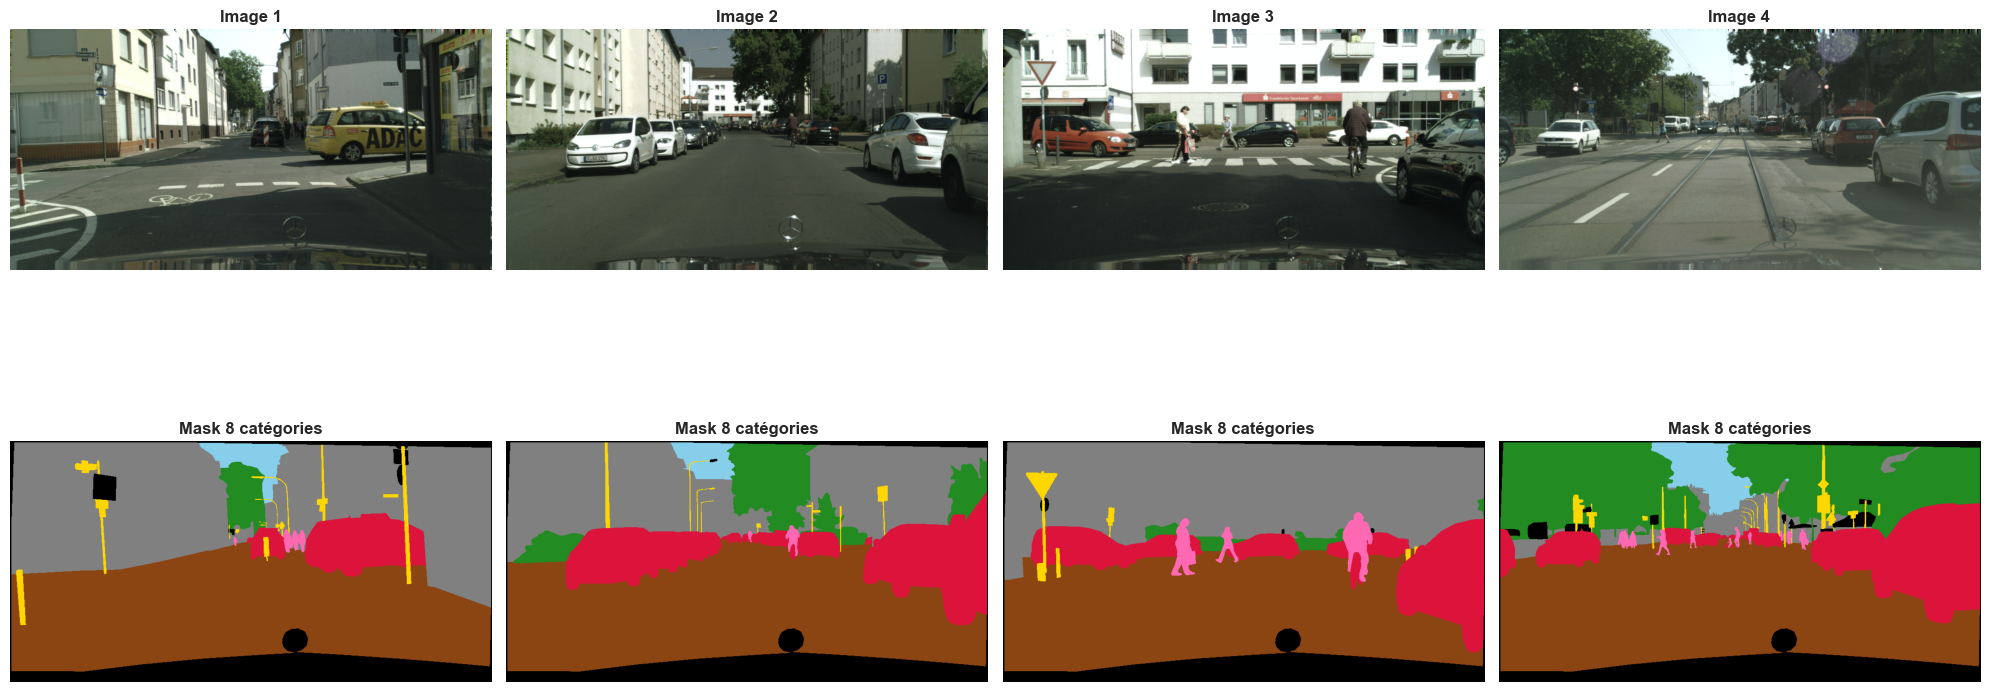

✅ Batch validé:
   • Shape images: (4, 512, 1024, 3)
   • Shape labels: (4, 512, 1024)
   • Valeurs images: [-2.118, 2.640]
   • Classes présentes: [0 1 2 3 4 5 6 7]
   • Distribution classes dans ce batch:
     - Classe 0: 37.41%
     - Classe 1: 26.51%
     - Classe 2: 1.22%
     - Classe 3: 9.35%
     - Classe 4: 1.68%
     - Classe 5: 0.78%
     - Classe 6: 11.76%
     - Classe 7: 11.29%


In [6]:
def visualize_generator_samples():
    """
    Visualise des échantillons du générateur pour validation
    """
    print("\n📊 VISUALISATION DES ÉCHANTILLONS")
    print("=" * 40)
    
    # Données de validation
    val_data = indexer.get_split_data('val', has_images_only=False)
    
    if len(val_data) == 0:
        print("❌ Aucune donnée de validation trouvée")
        return
    
    # Générateur de test
    test_generator = CityscapesSequence(
        val_data[:20],  # Premier 20 échantillons
        batch_size=4,
        input_shape=GENERATOR_CONFIG['input_shape'],
        shuffle=False,
        use_cache=True
    )
    
    # Chargement d'un batch
    try:
        batch_x, batch_y = test_generator[0]
        
        # Mapping des couleurs pour les 8 catégories
        category_colors = np.array([
            [139, 69, 19],   # road - brown
            [128, 128, 128], # building - gray
            [255, 215, 0],   # object - gold
            [34, 139, 34],   # nature - green
            [135, 206, 235], # sky - sky blue
            [255, 105, 180], # person - hot pink
            [220, 20, 60],   # vehicle - crimson
            [0, 0, 0]        # void - black
        ], dtype=np.uint8)
        
        # Visualisation
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        
        for i in range(min(4, batch_x.shape[0])):
            # Image originale (dénormalisation pour affichage)
            if GENERATOR_CONFIG['preprocessing']['normalization'] == 'imagenet':
                # Inverse de la normalisation ImageNet
                mean = np.array([123.675, 116.28, 103.53])
                std = np.array([58.395, 57.12, 57.375])
                img_display = (batch_x[i] * std + mean) / 255.0
                img_display = np.clip(img_display, 0, 1)
            else:
                img_display = np.clip(batch_x[i], 0, 1)
            
            axes[0, i].imshow(img_display)
            axes[0, i].set_title(f'Image {i+1}', fontweight='bold')
            axes[0, i].axis('off')
            
            # Mask coloré
            label_colored = category_colors[batch_y[i]]
            axes[1, i].imshow(label_colored)
            axes[1, i].set_title(f'Mask 8 catégories', fontweight='bold')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / "generator_samples.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Statistiques du batch
        print(f"✅ Batch validé:")
        print(f"   • Shape images: {batch_x.shape}")
        print(f"   • Shape labels: {batch_y.shape}")
        print(f"   • Valeurs images: [{batch_x.min():.3f}, {batch_x.max():.3f}]")
        print(f"   • Classes présentes: {np.unique(batch_y)}")
        
        # Distribution des classes dans ce batch
        unique_classes, counts = np.unique(batch_y, return_counts=True)
        total_pixels = batch_y.size
        
        print(f"   • Distribution classes dans ce batch:")
        for class_id, count in zip(unique_classes, counts):
            percentage = (count / total_pixels) * 100
            print(f"     - Classe {class_id}: {percentage:.2f}%")
        
    except Exception as e:
        print(f"❌ Erreur visualisation: {e}")

# Visualisation des échantillons
visualize_generator_samples()

## 🔍 Analyse de la Distribution des Classes


🔍 ANALYSE DISTRIBUTION CLASSES - GÉNÉRATEUR
✅ CityscapesSequence initialisé:
   • Échantillons: 50
   • Batch size: 8
   • Batches par époque: 7
   • Cache activé: True
📊 Analyse sur 50 échantillons...


Analyse batches:   0%|          | 0/7 [00:00<?, ?it/s]


📈 Distribution sur 7 batches (26,214,400 pixels):
   0. ROAD        :  38.16% (10,002,257 pixels)
   1. BUILDING    :  26.02% (6,820,028 pixels)
   2. OBJECT      :   1.76% (461,640 pixels)
   3. NATURE      :  13.84% (3,628,984 pixels)
   4. SKY         :   1.81% (475,783 pixels)
   5. PERSON      :   1.59% (418,022 pixels)
   6. VEHICLE     :   7.03% (1,842,353 pixels)
   7. VOID        :   9.79% (2,565,333 pixels)


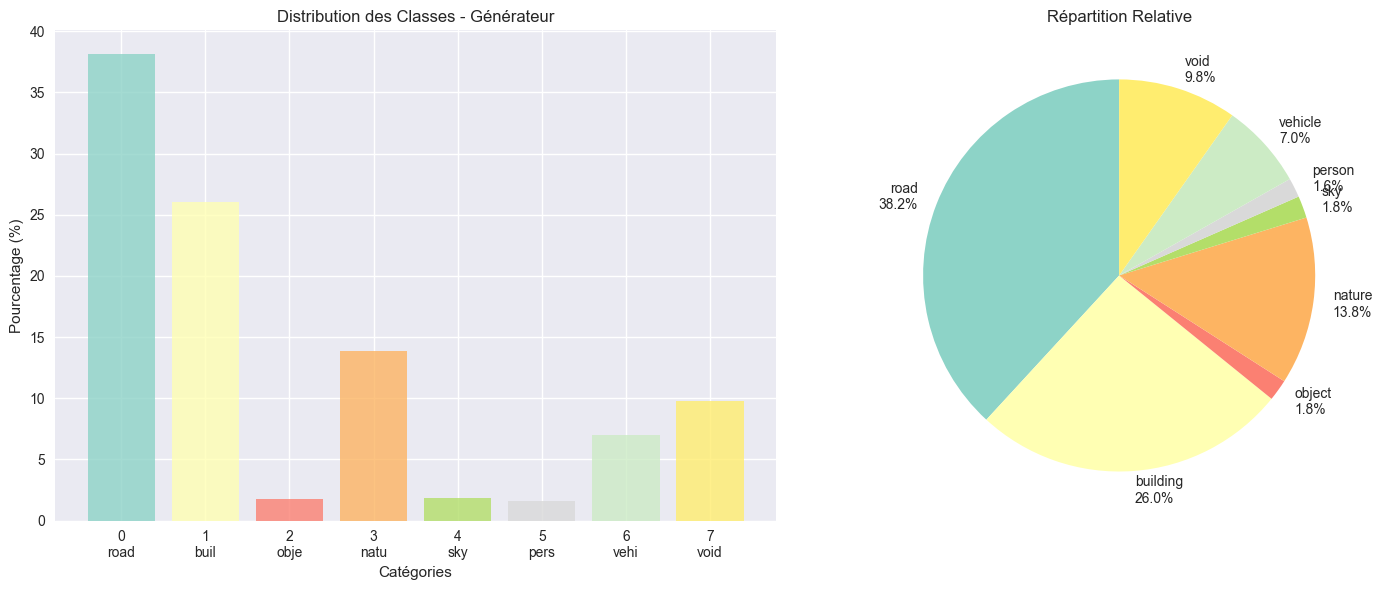

In [7]:
def analyze_class_distribution_generator():
    """
    Analyse la distribution des classes dans les données générées
    """
    print("\n🔍 ANALYSE DISTRIBUTION CLASSES - GÉNÉRATEUR")
    print("=" * 50)
    
    # Données d'entraînement
    train_data = indexer.get_split_data('train', has_images_only=False)
    
    if len(train_data) == 0:
        print("❌ Aucune donnée disponible")
        return None
    
    # Générateur pour analyse (échantillon représentatif)
    sample_size = min(50, len(train_data))
    analysis_generator = CityscapesSequence(
        train_data[:sample_size],
        batch_size=8,
        input_shape=GENERATOR_CONFIG['input_shape'],
        shuffle=False,
        use_cache=True
    )
    
    # Collecte des statistiques
    class_counts = np.zeros(GENERATOR_CONFIG['num_classes'], dtype=np.int64)
    total_pixels = 0
    processed_batches = 0
    
    print(f"📊 Analyse sur {sample_size} échantillons...")
    
    try:
        for batch_idx in tqdm(range(len(analysis_generator)), desc="Analyse batches"):
            batch_x, batch_y = analysis_generator[batch_idx]
            
            # Comptage des pixels par classe
            unique_classes, counts = np.unique(batch_y, return_counts=True)
            for class_id, count in zip(unique_classes, counts):
                if class_id < GENERATOR_CONFIG['num_classes']:
                    class_counts[class_id] += count
            
            total_pixels += batch_y.size
            processed_batches += 1
    
    except Exception as e:
        print(f"⚠️ Erreur durant l'analyse: {e}")
    
    if total_pixels > 0:
        # Calcul des pourcentages
        class_percentages = (class_counts / total_pixels) * 100
        
        # Affichage des résultats
        print(f"\n📈 Distribution sur {processed_batches} batches ({total_pixels:,} pixels):")
        
        # Noms des catégories
        category_names = ['road', 'building', 'object', 'nature', 'sky', 'person', 'vehicle', 'void']
        
        distribution_data = []
        for i in range(GENERATOR_CONFIG['num_classes']):
            name = category_names[i] if i < len(category_names) else f'class_{i}'
            print(f"   {i}. {name.upper():12}: {class_percentages[i]:6.2f}% ({class_counts[i]:,} pixels)")
            distribution_data.append({
                'class_id': i,
                'category': name,
                'percentage': class_percentages[i],
                'pixel_count': class_counts[i]
            })
        
        # Sauvegarde des résultats
        df_generator_dist = pd.DataFrame(distribution_data)
        df_generator_dist.to_csv(OUTPUTS_DIR / "generator_class_distribution.csv", index=False)
        
        # Visualisation
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Barres
        bars = ax1.bar(range(GENERATOR_CONFIG['num_classes']), class_percentages, 
                      color=plt.cm.Set3(np.linspace(0, 1, GENERATOR_CONFIG['num_classes'])), alpha=0.8)
        ax1.set_xlabel('Catégories')
        ax1.set_ylabel('Pourcentage (%)')
        ax1.set_title('Distribution des Classes - Générateur')
        ax1.set_xticks(range(GENERATOR_CONFIG['num_classes']))
        ax1.set_xticklabels([f'{i}\n{category_names[i][:4]}' for i in range(GENERATOR_CONFIG['num_classes'])])
        
        # Camembert
        ax2.pie(class_percentages, labels=[f'{category_names[i]}\n{class_percentages[i]:.1f}%' 
                                          for i in range(GENERATOR_CONFIG['num_classes'])],
               autopct='', startangle=90, 
               colors=plt.cm.Set3(np.linspace(0, 1, GENERATOR_CONFIG['num_classes'])))
        ax2.set_title('Répartition Relative')
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / "generator_class_distribution.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        return df_generator_dist
    
    return None

# Analyse de la distribution
distribution_analysis = analyze_class_distribution_generator()

## ⚙️ Factory et Utilitaires

In [8]:
class GeneratorFactory:
    """
    Factory pour créer différents types de générateurs selon les besoins
    """
    
    @staticmethod
    def create_train_generator(data_list, batch_size=16, augmentations=None):
        """
        Générateur pour l'entraînement avec toutes les optimisations
        """
        return CityscapesSequence(
            data_list=data_list,
            batch_size=batch_size,
            input_shape=GENERATOR_CONFIG['input_shape'],
            num_classes=GENERATOR_CONFIG['num_classes'],
            shuffle=True,
            augmentations=augmentations,
            use_cache=True
        )
    
    @staticmethod
    def create_val_generator(data_list, batch_size=16):
        """
        Générateur pour la validation (pas de shuffle, pas d'augmentation)
        """
        return CityscapesSequence(
            data_list=data_list,
            batch_size=batch_size,
            input_shape=GENERATOR_CONFIG['input_shape'],
            num_classes=GENERATOR_CONFIG['num_classes'],
            shuffle=False,
            augmentations=None,
            use_cache=True
        )
    
    @staticmethod
    def create_inference_generator(data_list, batch_size=1):
        """
        Générateur pour l'inférence (batch_size=1, optimisations max)
        """
        return CityscapesSequence(
            data_list=data_list,
            batch_size=batch_size,
            input_shape=GENERATOR_CONFIG['input_shape'],
            num_classes=GENERATOR_CONFIG['num_classes'],
            shuffle=False,
            augmentations=None,
            use_cache=True
        )

def get_memory_usage():
    """
    Retourne l'usage mémoire actuel
    """
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    return {
        'rss_mb': memory_info.rss / 1024 / 1024,  # Mémoire physique
        'vms_mb': memory_info.vms / 1024 / 1024,  # Mémoire virtuelle
        'percent': process.memory_percent()
    }

def create_data_splits():
    """
    Crée les splits train/val/test avec statistiques
    """
    print("\n⚙️ CRÉATION DES SPLITS DE DONNÉES")
    print("=" * 40)
    
    splits_info = {}
    
    for split_name in ['train', 'val', 'test']:
        data = indexer.get_split_data(split_name, has_images_only=False)
        
        # Statistiques
        total_samples = len(data)
        with_images = sum(1 for item in data if item['image_path'] is not None)
        cities = len(set(item['city'] for item in data))
        
        splits_info[split_name] = {
            'total_samples': total_samples,
            'with_images': with_images,
            'cities': cities,
            'data': data
        }
        
        print(f"📊 {split_name.upper()}:")
        print(f"   • Échantillons total: {total_samples}")
        print(f"   • Avec images: {with_images}")
        print(f"   • Villes: {cities}")
    
    return splits_info

# Création des splits
splits_data = create_data_splits()


⚙️ CRÉATION DES SPLITS DE DONNÉES
📊 TRAIN:
   • Échantillons total: 2975
   • Avec images: 2975
   • Villes: 18
📊 VAL:
   • Échantillons total: 500
   • Avec images: 500
   • Villes: 3
📊 TEST:
   • Échantillons total: 0
   • Avec images: 0
   • Villes: 0


## 💾 Sauvegarde et Configuration

In [ ]:
def save_generator_configuration():
    """
    Sauvegarde la configuration complète du générateur
    """
    
    # Configuration finale
    generator_config = {
        'generator_settings': GENERATOR_CONFIG,
        'class_mapping': {
            'num_classes': GENERATOR_CONFIG['num_classes'],
            'mapping_array_size': len(ID_TO_8_CATEGORIES),
            'mapping_file': 'class_mapping.json'
        },
        'dataset_statistics': {
            'total_samples': sum(info['total_samples'] for info in splits_data.values()),
            'splits': {name: {'samples': info['total_samples'], 'cities': info['cities']} 
                      for name, info in splits_data.items()}
        },
        'performance_benchmarks': benchmark_results if benchmark_results else [],
        'memory_optimization': {
            'cache_enabled': GENERATOR_CONFIG['performance']['use_cache'],
            'cache_size': GENERATOR_CONFIG['performance']['cache_size'],
            'lazy_loading': True,
            'preprocessing_pipeline': 'optimized'
        },
        'usage_examples': {
            'training': "GeneratorFactory.create_train_generator(train_data, batch_size=16)",
            'validation': "GeneratorFactory.create_val_generator(val_data, batch_size=16)",
            'inference': "GeneratorFactory.create_inference_generator(test_data, batch_size=1)"
        }
    }
    
    # Sauvegarde
    with open(OUTPUTS_DIR / "data_generator_config.json", 'w') as f:
        json.dump(generator_config, f, indent=2, default=str)
    
    # Métriques de performance actuelles
    memory_usage = get_memory_usage()
    
    print("\n💾 SAUVEGARDE CONFIGURATION GÉNÉRATEUR")
    print("=" * 50)
    print(f"✅ Configuration sauvegardée: {OUTPUTS_DIR / 'data_generator_config.json'}")
    print(f"✅ Index dataset sauvegardé: {OUTPUTS_DIR / 'dataset_index.json'}")
    print(f"✅ Distribution classes: {OUTPUTS_DIR / 'generator_class_distribution.csv'}")
    
    print(f"\n📊 État du système:")
    print(f"   • Mémoire utilisée: {memory_usage['rss_mb']:.1f} MB ({memory_usage['percent']:.1f}%)")
    print(f"   • Échantillons indexés: {sum(info['total_samples'] for info in splits_data.values())}")
    print(f"   • Cache activé: {GENERATOR_CONFIG['performance']['use_cache']}")
    
    return generator_config

# Sauvegarde finale
final_config = save_generator_configuration()

# Test final de compatibilité
print(f"\n🧪 TEST FINAL DE COMPATIBILITÉ")
print("=" * 40)

try:
    # Test générateur train
    train_data_sample = splits_data['train']['data'][:10]
    if train_data_sample:
        test_gen = GeneratorFactory.create_train_generator(train_data_sample, batch_size=2)
        test_batch_x, test_batch_y = test_gen[0]
        
        print(f"✅ Générateur train: OK ({test_batch_x.shape}, {test_batch_y.shape})")
        print(f"✅ Shapes compatibles TensorFlow/Keras")
        print(f"✅ Types de données: {test_batch_x.dtype}, {test_batch_y.dtype}")
        
        # Nettoyage
        del test_gen, test_batch_x, test_batch_y
        gc.collect()
    else:
        print("⚠️ Pas de données d'entraînement disponibles pour le test")
        
except Exception as e:
    print(f"❌ Erreur test compatibilité: {e}")

print(f"\n🏆 RÉSUMÉ FINAL - GÉNÉRATEUR DE DONNÉES")
print("=" * 60)
print(f"✅ CityscapesSequence implémenté avec optimisations avancées")
print(f"✅ Cache LRU, chargement lazy, conversion automatique 34→8")
print(f"✅ Factory pattern pour différents types de générateurs")
print(f"✅ Benchmark et validation réalisés")
print(f"✅ Compatible tf.keras.utils.Sequence")


💾 SAUVEGARDE CONFIGURATION GÉNÉRATEUR
✅ Configuration sauvegardée: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\data_generator_config.json
✅ Index dataset sauvegardé: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\dataset_index.json
✅ Distribution classes: C:\Tonton\OpenClassrooms\Projet_7_traiter_images_systeme_embarque_voiture_autonome\notebooks\outputs\generator_class_distribution.csv

📊 État du système:
   • Mémoire utilisée: 783.0 MB (1.2%)
   • Échantillons indexés: 3475
   • Cache activé: True

🧪 TEST FINAL DE COMPATIBILITÉ
✅ CityscapesSequence initialisé:
   • Échantillons: 10
   • Batch size: 2
   • Batches par époque: 5
   • Cache activé: True
✅ Générateur train: OK ((2, 512, 1024, 3), (2, 512, 1024))
✅ Shapes compatibles TensorFlow/Keras
✅ Types de données: float32, uint8

🏆 RÉSUMÉ FINAL - GÉNÉRATEUR DE DONNÉES
✅ CityscapesSequence implémenté avec optimisations avan